In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings; warnings.simplefilter('ignore')
from csv import reader

In [2]:
'''
GET LIST OF EDGES FROM CSV FILE
'''

#file = 'dolphin.csv'
file = 'football.csv'
#file = 'karate.csv'
nodes = []
edge_list = []
with open(file, 'r') as read_obj:
    csv_reader = reader(read_obj)
    count = 0
    for row in csv_reader:
        if count != 0:
            xx, yy = row
            x = int(xx) - 1
            y = int(yy) - 1
            edge_list.append((int(x),int(y)))
            if x not in nodes:
                nodes.append(x)
            if y not in nodes:
                nodes.append(y)
        count += 1

In [3]:
'''
CREATE GRAPH FROM LIST OF EDGES
'''

G = nx.Graph()
G.add_edges_from(edge_list)
len(G)

115

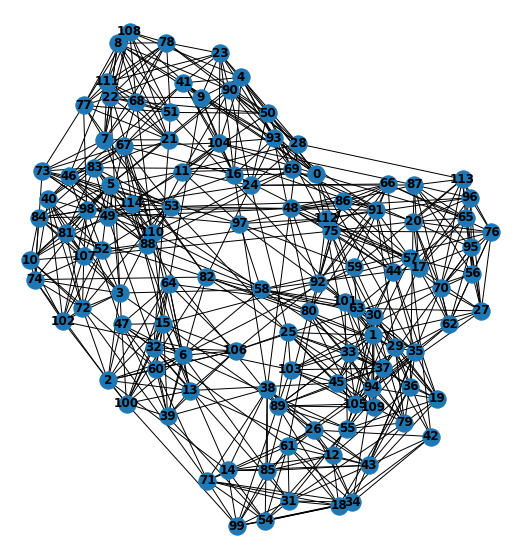

In [4]:
'''
PLOT ORIGINAL GRAPH
'''

plt.figure(figsize = (20, 10))
plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold')

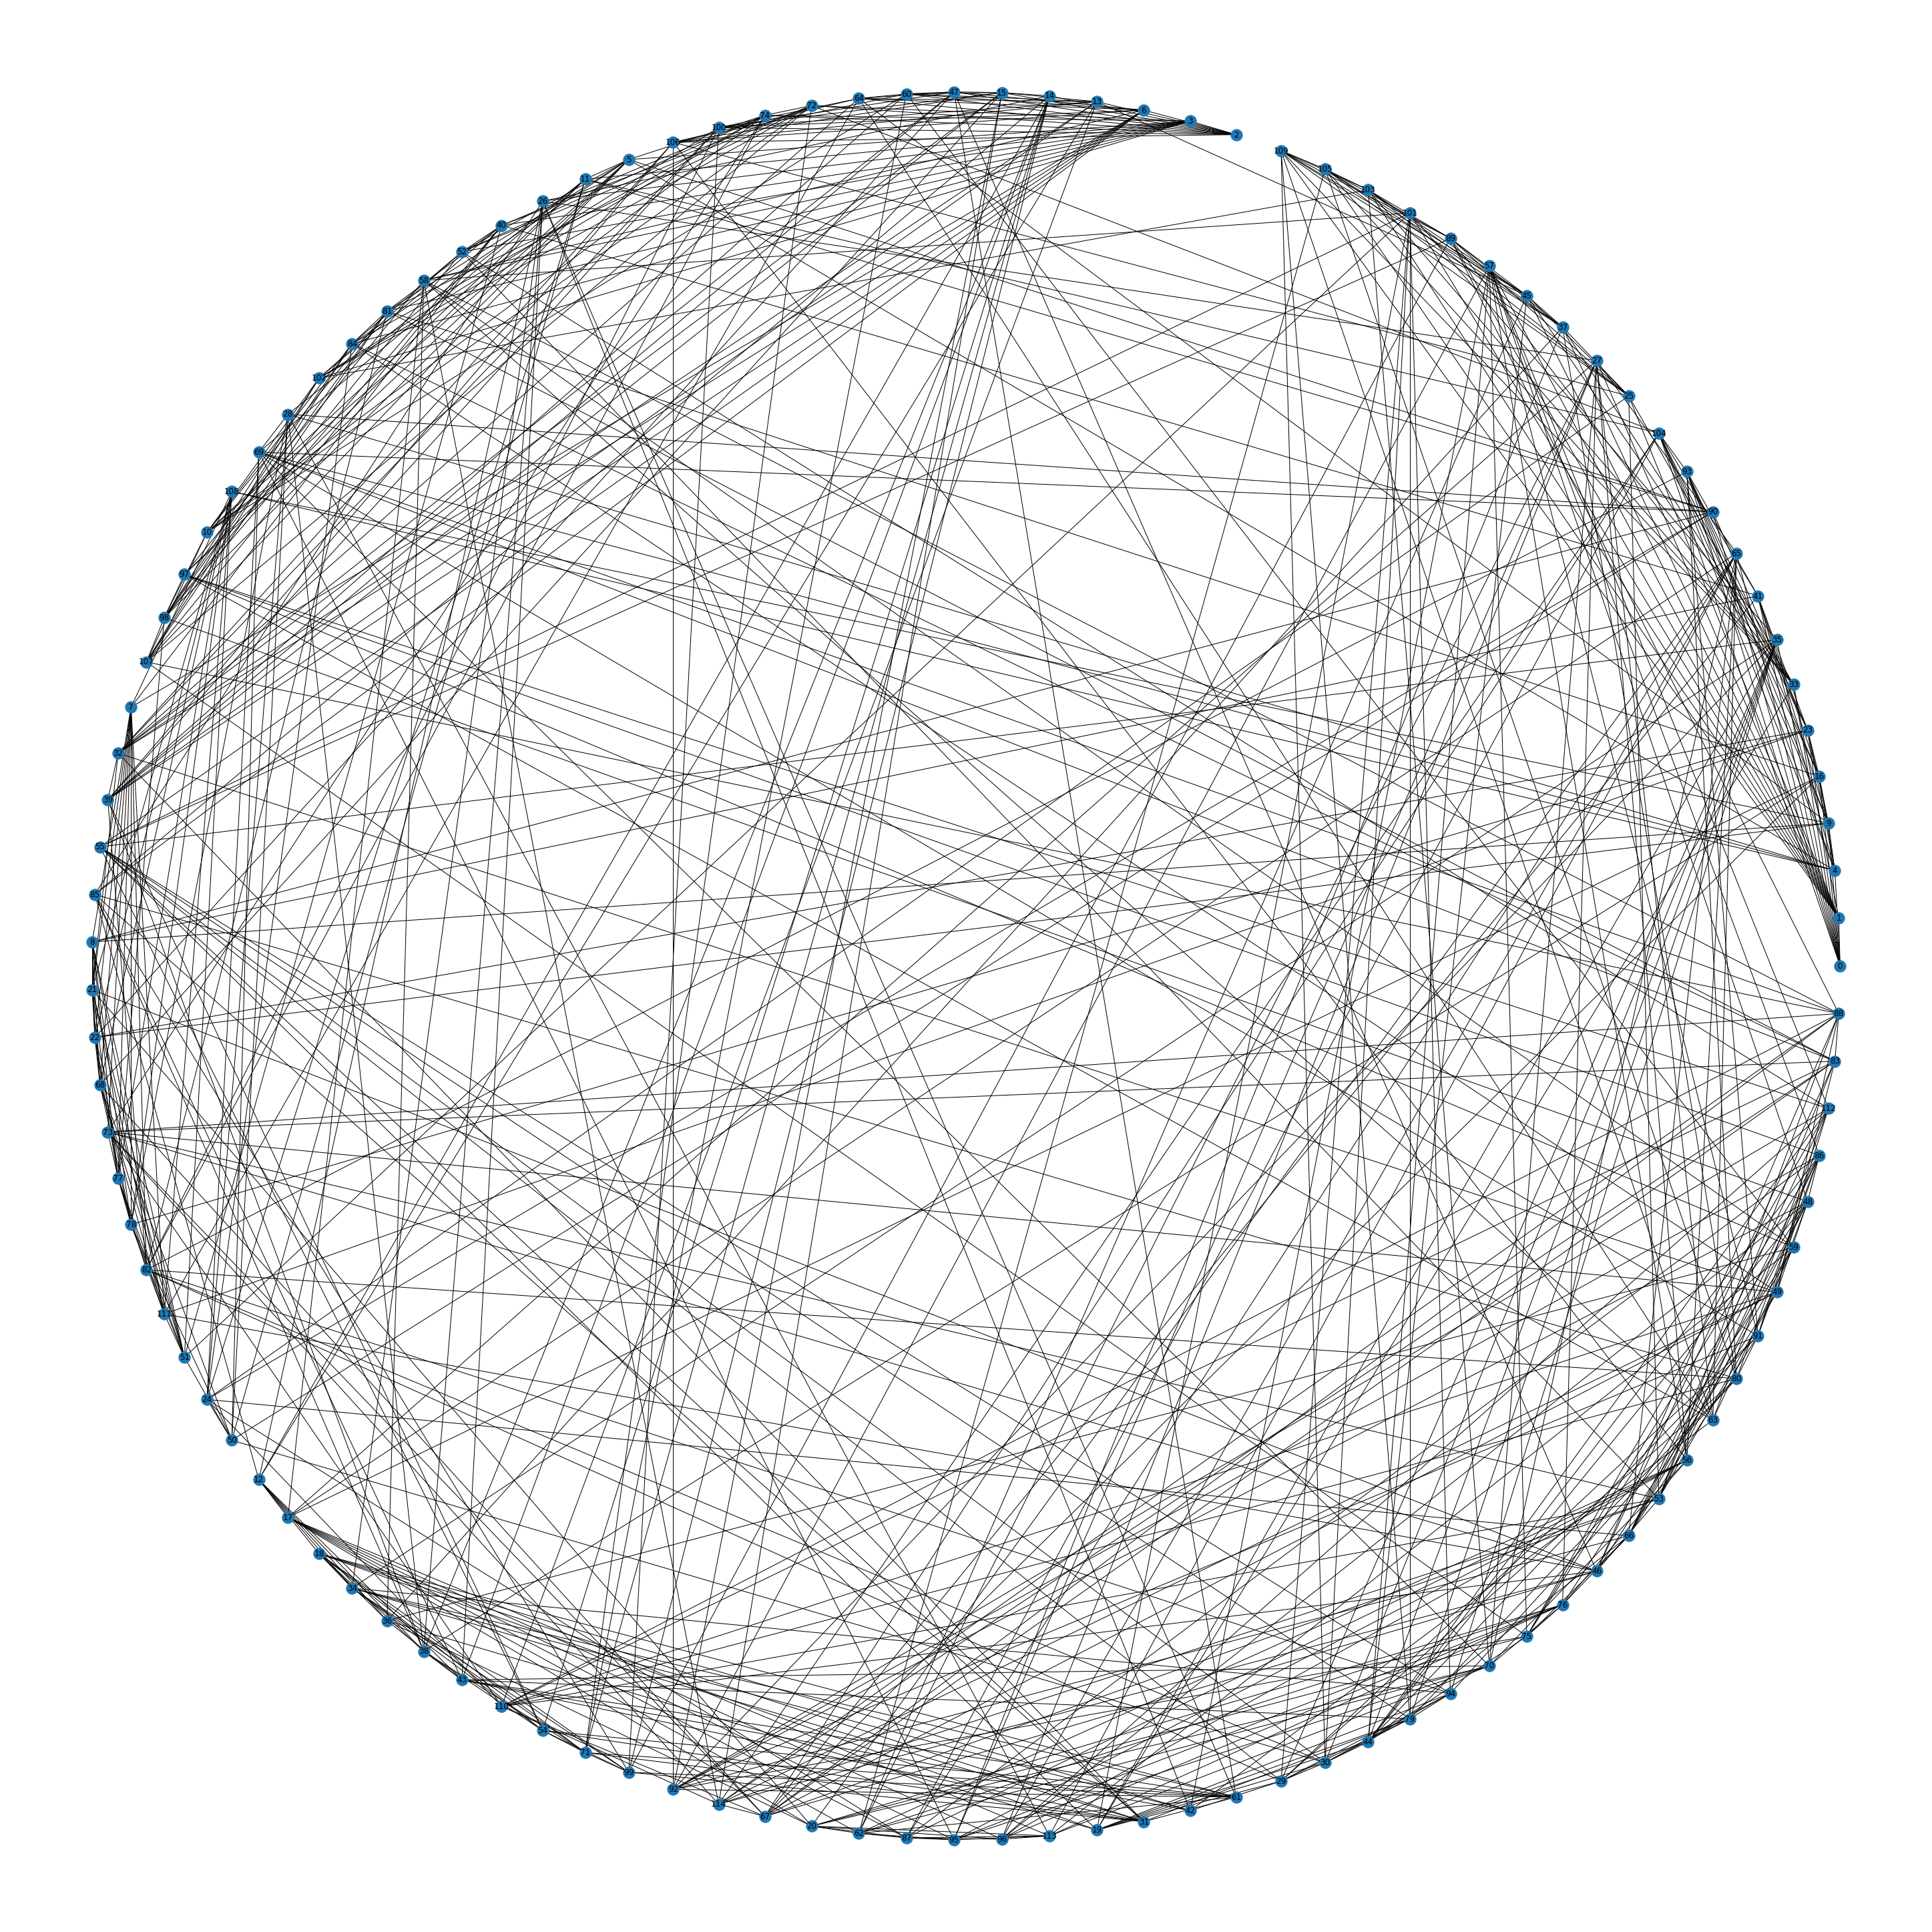

In [5]:
'''
PLOT CIRCULAR GRAPH
'''

plt.figure(figsize=(40,40))
nx.draw_circular(G, with_labels = True)

In [6]:
'''
GET ADJACENCY MATRIX FROM GRAPH
'''

Adj_matrix = nx.adjacency_matrix(G).todense().tolist()

In [7]:
'''
PARAMETERS FOR THE SIMULATION
'''

ntimes = 10
lamda = 0.9
mu = 0.8

In [8]:
'''
SIMULATION OF THE SPREADING PROCESS WITH A SINGLE NODE INFECTED
'''

def run_simulation(G, times, Prob_R, Prob_S, Prob_I):
    temp_Prob_R, temp_Prob_S, temp_Prob_I = Prob_R, Prob_S, Prob_I
    for t in range(1, times+1):
        # calculate Prob_S for every node
        for node in nodes:
            Prob_S[node] = temp_Prob_S[node]
            mult = 1
            for n in nodes:
                mult *= (1 - lamda * Adj_matrix[n][node] * temp_Prob_I[n])
            Prob_S[node] *= mult
        # calculate Prob_I for every node
        for node in nodes:
            Prob_I[node] = temp_Prob_S[node]
            mult = 1
            for n in nodes:
                mult *= (lamda * Adj_matrix[n][node] * temp_Prob_I[n])
            Prob_I[node] *= (1 - mult)
            Prob_I[node] += (1 - mu) * temp_Prob_I[node]
        # calculate Prob_R for every node
        for node in nodes:
            Prob_R[node] = mu * temp_Prob_I[node] + temp_Prob_R[node]
        temp_Prob_S, temp_Prob_I, temp_Prob_R = Prob_S, Prob_I, Prob_R
    return temp_Prob_S, temp_Prob_I, temp_Prob_R

In [9]:
'''
INFECT EVERY NODE AND FILL THE PROBABILITY MATRIX
'''

nodes = list(G.nodes())

Prob_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]

for node in nodes:
    Prob_R = [0 for _ in range(len(nodes))]
    Prob_S = [mu for _ in range(len(nodes))]
    Prob_I = [0 for _ in range(len(nodes))]
    
    Prob_I[node] = 1
    
    Prob_S, Prob_I, Prob_R = run_simulation(G, ntimes, Prob_R, Prob_S, Prob_I)
    
    for n in nodes:
        Prob_matrix[n][node] = Prob_R[n]

In [10]:
'''
CALCULATE PARTITION MATRIX FROM PROBABILITY MATRIX
'''

Part_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            Part_matrix[i][j] = Prob_matrix[i][j]
        else:
            x = 0
            for jj in range(len(nodes)):
                if jj != i:
                    x += Prob_matrix[i][jj]
            Part_matrix[i][j] = x / (len(nodes)-1)

In [11]:
means = [0 for _ in range(len(nodes))]
sds = [0 for _ in range(len(nodes))]

In [12]:
for i in range(len(nodes)):
    means[i] = sum(Part_matrix[i])/(len(nodes))

In [13]:
for i in range(len(nodes)):
    x = 0
    for k in range(len(nodes)):
        x += (Part_matrix[i][k] - means[i])*(Part_matrix[i][k] - means[i])
    x /= len(nodes)
    sds[i] = math.sqrt(x)

In [14]:
'''
CALCULATE PEARSON CORRELATION MATRIX FROM PARTITION MATRIX
'''

Pear_cor = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
    for j in range(len(nodes)):
        x = 0
        for k in range(len(nodes)):
            x += (Part_matrix[i][k]-means[i])*(Part_matrix[j][k]-means[j])
        x /= (len(nodes)*sds[i]*sds[j])
        Pear_cor[i][j] = x

In [15]:
'''
CALCULATE DISTANCE MATRIX FROM PEARSON CORRELATION MATRIX
'''

Distance_matrix = [[0 for i in range(len(nodes))] for j in range(len(nodes))]
for i in range(len(nodes)):
    for j in range(len(nodes)):
        Distance_matrix[i][j] = 1 - Pear_cor[i][j]

In [16]:
'''
PERFORM CLUSTERING BASED ON THE DISTANCE MATRIX
'''

cluster = AgglomerativeClustering(n_clusters=6, affinity='precomputed', linkage='single')
cluster.fit(Distance_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='single', n_clusters=6)

In [17]:
colors = cluster.labels_
colors

array([1, 3, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 1, 3, 0, 3, 3, 0, 3, 0, 3, 3,
       3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 5, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 4, 0, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 2, 0, 0, 5, 0,
       0, 0, 0, 5, 5])

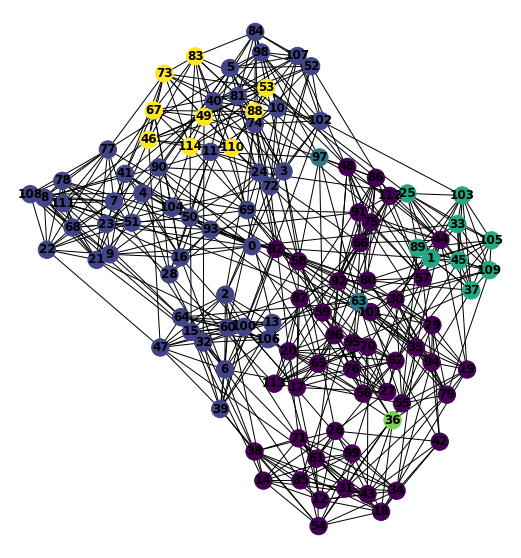

In [18]:
'''
GRAPH AFTER CLUSTERING
'''

plt.figure(figsize = (20, 10))
plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold', node_color=colors)

In [19]:
data = []

for i in range(len(colors)):
    data.append([i, colors[i]])

df = pd.DataFrame(data, columns = ['Node', 'Cluster'])

In [20]:
df

Node  Cluster
0       0        1
1       1        3
2       2        1
3       3        1
4       4        1
..    ...      ...
110   110        0
111   111        0
112   112        0
113   113        5
114   114        5

[115 rows x 2 columns]

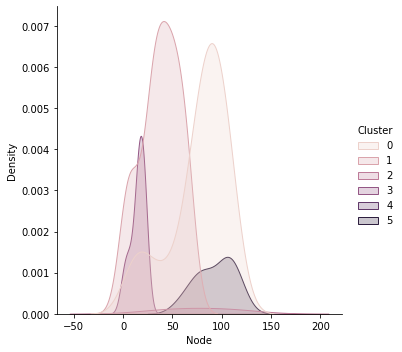

In [21]:
'''
DENSITY PLOT FOR DIFFERENT CLUSTERS
'''
sns.displot(df, x="Node", hue="Cluster", kind="kde", fill=True)

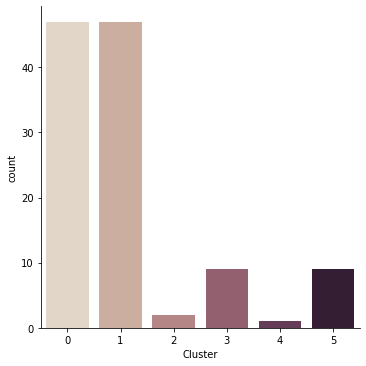

In [22]:
'''
HOW MANY NODES IN EACH CLUSTER
'''
sns.catplot(x="Cluster", kind="count", palette="ch:.25", data=df)

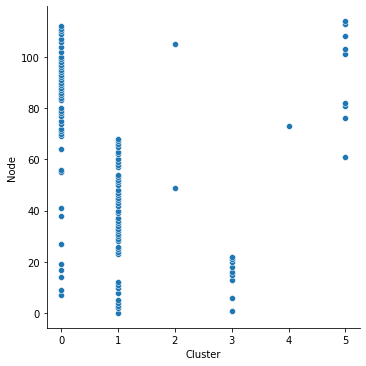

In [23]:
'''
WHICH CLUSTER CONTAINS WHICH NODES
'''
sns.relplot(data=df, x="Cluster", y="Node")